# Preamble

In [1]:
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

In [2]:
# Whether or not to save matplotlib figures as pdf output file for latex
USE_LATEX_ENGINE = True

if USE_LATEX_ENGINE:
    import matplotlib
    # matplotlib.use("pgf")     # pgf doesn't work for some plots because they exceed the max value that pgf can calculate
    matplotlib.rcParams.update({
        # "pgf.texsystem": "pdflatex",
        # 'pgf.rcfonts': False,
        'font.family': 'serif',
        'text.usetex': True,
    })

# Function Definitions

In [3]:
def _generate_output_string(element, data):
    """
    Returns a string that contains information about the percentual share of a value in a list
    """
    # if not isinstance(element, str): # make sure element is of type string, convert otherwise
    #     element = str(element)
    
    n_total = len(data)
    bool_list = (data == element)
    n_elements = sum(bool_list)

    return "{:<30}".format(str(n_elements) + '/' + str(n_total) + ' (' + "{:.2f}".format(((n_elements / n_total) * 100)) + '%)')

In [4]:
def calculate_percentages(normal_data, pneumonia_data, additional_df=None):
    """
    checks if two lists contain the same set of values - returns a warning if the sets dont match - prints a string with information about the distribution if they match
    """
    if len(set(normal_data)) is not len(set(pneumonia_data)):
        print('WARNING! Categories of healthy and pneumonia data are not identical!')
        print('Normal: ' + str(set(normal_data)))
        print('Pneumonia: ' + str(set(pneumonia_data)))
        print('Number of appearences (normal):')
        n_normal_set = ''
        for category in set(normal_data):
            n_normal_set += "'" + str(category) + "': " + str(sum(normal_data == category)) + '\n'   # single quote: non-escaped string, double quote: escaped string
        print(n_normal_set)
        return
    else:
        print(set(normal_data))
    if additional_df is None:
        print('{:<21}'.format('') + '{:<30}'.format('normal') + '{:<30}'.format('pneumonia'))
    else:
        print('{:<21}'.format('') + '{:<30}'.format('normal (total)') + '{:<30}'.format('normal (filtered)') + '{:<30}'.format('pneumonia'))

    for element in set(normal_data):
        category_string = "{:<21}".format(str(element) + ': ')
        if additional_df is None:
            print(category_string + _generate_output_string(element, normal_data) + _generate_output_string(element, pneumonia_data))
        else:
            print(category_string + _generate_output_string(element, normal_data) + _generate_output_string(element, additional_df) + _generate_output_string(element, pneumonia_data))

In [5]:
def find_appearences(df, column, value):
    """
    searches for appearences of a specified value within the column of a dataframe - prints the number of appearences and the corresponding indexes
    """
    
    value = str(value)
    print('found ' + str(sum(df[column] == value)) + ' rows')
    index_list = df.index[df[column] == value].tolist()
    print('Indexes: ' + str(index_list))
    return index_list

In [6]:
def drop_from_column(df, column, value):
    """
    searches for appearences of a specified value within a column of a dataframe - drops each row where the value appeared from the dataframe
    """
    value = str(value)
    print('Dropping ' + str(sum(df[column] == value)) + ' rows')
    index_list = df.index[df[column] == value].tolist()
    df.drop(index_list, inplace=True)

# Data preparation

In [7]:
# this used to be done in a python script
path_padchest = '/mnt/f/BIMCV-PadChest/unzipped/'
file_name_meta_data = 'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv'

meta_data = pd.read_csv(path_padchest + file_name_meta_data, engine='python')
meta_data.reset_index(drop=True, inplace=True)

In [8]:
meta_data.dtypes

Unnamed: 0                           int64
ImageID                             object
ImageDir                             int64
StudyDate_DICOM                      int64
StudyID                             object
PatientID                           object
PatientBirth                       float64
PatientSex_DICOM                    object
ViewPosition_DICOM                  object
Projection                          object
MethodProjection                    object
Pediatric                           object
Modality_DICOM                      object
Manufacturer_DICOM                  object
PhotometricInterpretation_DICOM     object
PixelRepresentation_DICOM            int64
PixelAspectRatio_DICOM              object
SpatialResolution_DICOM             object
BitsStored_DICOM                     int64
WindowCenter_DICOM                  object
WindowWidth_DICOM                   object
Rows_DICOM                           int64
Columns_DICOM                        int64
XRayTubeCur

In [9]:
meta_data.head().iloc[0]

Unnamed: 0                                                                         0
ImageID                            20536686640136348236148679891455886468_k6ga29.png
ImageDir                                                                           0
StudyDate_DICOM                                                             20140915
StudyID                                       20536686640136348236148679891455886468
PatientID                                       839860488694292331637988235681460987
PatientBirth                                                                    1930
PatientSex_DICOM                                                                   F
ViewPosition_DICOM                                                   POSTEROANTERIOR
Projection                                                                        PA
MethodProjection                                       Manual review of DICOM fields
Pediatric                                                        

In [10]:
replace_nan_with = 'nan'
print('Replacing ' + str(meta_data.isnull().sum().sum()) + ' appearances of NaN with: ' + str(replace_nan_with))
meta_data.fillna(replace_nan_with, inplace=True)   # be careful, this modifies the original dataframe

#print('Replacing ' + str(pneumonia_meta_data.isnull().sum().sum()) + ' appearances of NaN with: ' + str(replace_nan_with))
#pneumonia_meta_data.fillna(replace_nan_with, inplace=True)   # be careful, this modifies the original dataframe

Replacing 69726 appearances of NaN with: nan


In [11]:
pneumonia_bool = [True if 'pneumonia' in data[31] else False for data in meta_data.values]
normal_bool = [True if "['normal']" == data[31] else False for data in meta_data.values]

In [12]:
sum(pneumonia_bool)

8174

In [13]:
sum(normal_bool)

50340

In [14]:
pneumonia_meta_data = meta_data[pneumonia_bool]
normal_meta_data = meta_data[normal_bool]

In [15]:
normal_meta_data.head().iloc[0] == meta_data.head().iloc[0]

Unnamed: 0                         True
ImageID                            True
ImageDir                           True
StudyDate_DICOM                    True
StudyID                            True
PatientID                          True
PatientBirth                       True
PatientSex_DICOM                   True
ViewPosition_DICOM                 True
Projection                         True
MethodProjection                   True
Pediatric                          True
Modality_DICOM                     True
Manufacturer_DICOM                 True
PhotometricInterpretation_DICOM    True
PixelRepresentation_DICOM          True
PixelAspectRatio_DICOM             True
SpatialResolution_DICOM            True
BitsStored_DICOM                   True
WindowCenter_DICOM                 True
WindowWidth_DICOM                  True
Rows_DICOM                         True
Columns_DICOM                      True
XRayTubeCurrent_DICOM              True
Exposure_DICOM                     True


In [16]:
# normal_meta_data = '/mnt/c/Users/Jan/Daten/Geschäftlich/Capgemini/scripts/tmp/filtered_PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv'
# pneumonia_meta_data = '/mnt/c/Users/Jan/Daten/Geschäftlich/Capgemini/scripts/tmp/filtered_pneumonia.csv'

# read csv files, engine='python' improves parsing, column differentiation, etc.
#normal_meta_data = pd.read_csv(normal_meta_data, engine='python')
#pneumonia_meta_data = pd.read_csv(pneumonia_meta_data, engine='python')
normal_meta_data.reset_index(drop=True, inplace=True)
pneumonia_meta_data.reset_index(drop=True, inplace=True)

In [17]:
qry = ''
qry = qry + 'Labels.str.contains("normal")'
qry = qry + ' & Labels.str.contains("pneumonia")'
print(qry)
res_norm = normal_meta_data.query(qry, engine='python')
res_pneu = pneumonia_meta_data.query(qry, engine='python')

print('Found', len(res_norm), 'overlappings in normal meta data and', len(res_pneu), 'in pneumonia meta data')

Labels.str.contains("normal") & Labels.str.contains("pneumonia")
Found 0 overlappings in normal meta data and 5 in pneumonia meta data


In [18]:
print(len(normal_meta_data))
normal_meta_data.drop(res_norm.index, inplace=True)
print(len(normal_meta_data))

print(len(pneumonia_meta_data))
pneumonia_meta_data.drop(res_pneu.index, inplace=True)
print(len(pneumonia_meta_data))

50340
50340
8174
8169
/home/jan/miniconda3/envs/embeddedIntelligence/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
# remove images with lateral perspective
drop_from_column(normal_meta_data, 'Projection', 'L')
drop_from_column(pneumonia_meta_data, 'Projection', 'L')

Dropping 14211 rows
Dropping 2931 rows


In [20]:
FIRST_GROUP_BOUNDARY = 12
SECOND_GROUP_BOUNDARY = 62

drop_from_column(normal_meta_data, 'PatientBirth', 'nan') # drop unknown birth years, since there's only one entry

# This is clearly not the fastest way to do this, as using df.loc in loops is not recommended
for df in [normal_meta_data, pneumonia_meta_data]:
    i = 0
    for row in df.itertuples():
        age = int(str(row.StudyDate_DICOM)[:4]) - int(row.PatientBirth)
        df.loc[row.Index, 'Age'] = age

        if 0 <= age <= FIRST_GROUP_BOUNDARY:
            df.loc[row.Index, 'AgeGroup'] = int(1)
        elif FIRST_GROUP_BOUNDARY < age <= SECOND_GROUP_BOUNDARY:
            df.loc[row.Index, 'AgeGroup'] = int(2)
        elif SECOND_GROUP_BOUNDARY < age:
            df.loc[row.Index, 'AgeGroup'] = int(3)
        else:
            raise ValueError("Calculated age was either below 0 or a non numerical type")

        if str(row.Projection) == 'AP_horizontal':
            i += 1
            df.loc[row.Index, 'ProjectionSimplified'] = 'AP'
        else:
            df.loc[row.Index, 'ProjectionSimplified'] = row.Projection
    print('Replaced AP_horizontal with AP', i, 'times')


Dropping 1 rows
/home/jan/miniconda3/envs/embeddedIntelligence/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jan/miniconda3/envs/embeddedIntelligence/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
Replaced AP_horizontal with AP 1061 times
Replaced AP_horizontal with AP 1330 times


# Data Analysis

In [21]:
print('==== Distribution of projections ====\n')

calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'])

find_appearences(normal_meta_data, 'Projection', 'UNK')
drop_from_column(normal_meta_data, 'Projection', 'UNK')

drop_from_column(normal_meta_data, 'Projection', 'COSTAL')
drop_from_column(pneumonia_meta_data, 'Projection', 'COSTAL')

calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'])

==== Distribution of projections ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'AP_horizontal', 'PA', 'UNK', 'COSTAL', 'AP'}
Pneumonia: {'PA', 'AP_horizontal', 'AP', 'COSTAL'}
Number of appearences (normal):
'AP_horizontal': 1061
'PA': 34242
'UNK': 1
'COSTAL': 212
'AP': 612

found 1 rows
Indexes: [43828]
Dropping 1 rows
Dropping 212 rows
Dropping 18 rows
{'PA', 'AP_horizontal', 'AP'}
                     normal                        pneumonia                     
PA:                  34242/35915 (95.34%)          3400/5220 (65.13%)            
AP_horizontal:       1061/35915 (2.95%)            1330/5220 (25.48%)            
AP:                  612/35915 (1.70%)             490/5220 (9.39%)              


In [22]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'])
calculate_percentages(normal_meta_data['AgeGroup'], pneumonia_meta_data['AgeGroup'])

{'PA', 'AP'}
                     normal                        pneumonia                     
PA:                  34242/35915 (95.34%)          3400/5220 (65.13%)            
AP:                  1673/35915 (4.66%)            1820/5220 (34.87%)            
{1.0, 2.0, 3.0}
                     normal                        pneumonia                     
1.0:                 1865/35915 (5.19%)            929/5220 (17.80%)             
2.0:                 25007/35915 (69.63%)          1754/5220 (33.60%)            
3.0:                 9043/35915 (25.18%)           2537/5220 (48.60%)            


In [23]:
print('==== Distribution of MethodLabel ====\n')

calculate_percentages(normal_meta_data['MethodLabel'], pneumonia_meta_data['MethodLabel'])

==== Distribution of MethodLabel ====

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           8925/35915 (24.85%)           1094/5220 (20.96%)            
RNN_model:           26990/35915 (75.15%)          4126/5220 (79.04%)            


In [24]:
print('==== Distribution of Patient Sex ====\n')

calculate_percentages(normal_meta_data['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])


==== Distribution of Patient Sex ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'M', 'nan', 'O', 'F'}
Pneumonia: {'M', 'F'}
Number of appearences (normal):
'M': 15282
'nan': 3
'O': 4
'F': 20626



In [25]:
calculate_percentages(normal_meta_data['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])

drop_from_column(normal_meta_data, 'PatientSex_DICOM', 'nan')     # drop 'U' and 'O' since they are heavily underrepresented
drop_from_column(normal_meta_data, 'PatientSex_DICOM', 'O')

calculate_percentages(normal_meta_data['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'M', 'nan', 'O', 'F'}
Pneumonia: {'M', 'F'}
Number of appearences (normal):
'M': 15282
'nan': 3
'O': 4
'F': 20626

Dropping 3 rows
Dropping 4 rows
{'M', 'F'}
                     normal                        pneumonia                     
M:                   15282/35908 (42.56%)          2962/5220 (56.74%)            
F:                   20626/35908 (57.44%)          2258/5220 (43.26%)            


In [26]:
print('==== Distribution of ExposureTime ====\n')

calculate_percentages(normal_meta_data['ExposureTime'], pneumonia_meta_data['ExposureTime'])


==== Distribution of ExposureTime ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'32', '12', '19', '8', '7', '20', '18', '85', '3', '14', '15', '5', '25', '500', '9', '17', '47', '0', '64', '2', '6', '50', '4', '11', '33', '160', '1', '80', '55', '16', '40', 'None', '13', '352', '10'}
Pneumonia: {'12', '8', '7', '20', '3', '5', '25', '9', '0', '64', '2', '6', '50', '4', '11', '80', '16', 'None', '13', '10'}
Number of appearences (normal):
'32': 2
'12': 100
'19': 1
'8': 903
'7': 490
'20': 4
'18': 1
'85': 1
'3': 158
'14': 9
'15': 4
'5': 2168
'25': 104
'500': 1
'9': 193
'17': 2
'47': 1
'0': 3194
'64': 16
'2': 12
'6': 1321
'50': 6
'4': 684
'11': 48
'33': 1
'160': 2
'1': 1
'80': 1
'55': 1
'16': 30
'40': 1
'None': 7584
'13': 17
'352': 1
'10': 18846



In [27]:
calculate_percentages(normal_meta_data['Exposure_DICOM'], pneumonia_meta_data['Exposure_DICOM'])

filtered_exposure_normal = [int(x) for x in normal_meta_data['Exposure_DICOM'] if str(x) != 'None']
filtered_exposure_pneumonia = [int(x) for x in pneumonia_meta_data['Exposure_DICOM'] if str(x) != 'None']
print(len(filtered_exposure_normal))
print(len(filtered_exposure_pneumonia))


WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'12', '8', '7', '20', '3', '35', '5', '25', '0', '2', '6', '4', '11', '1', '80', '30', '40', 'None', '10'}
Pneumonia: {'20', '3', '12', '2', 'None', '4', '5', '25', '6', '8', '0', '10', '1'}
Number of appearences (normal):
'12': 45
'8': 12
'7': 1
'20': 6
'3': 5590
'35': 1
'5': 52
'25': 2
'0': 3194
'2': 17384
'6': 39
'4': 219
'11': 1
'1': 1746
'80': 1
'30': 1
'40': 1
'None': 7584
'10': 29

28324
2664


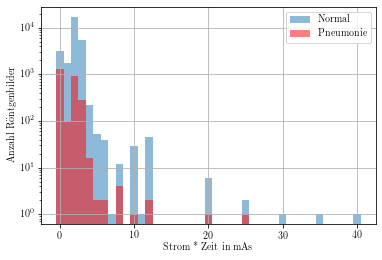

In [28]:
filtered_exposure_normal = sorted(filtered_exposure_normal)
filtered_exposure_pneumonia = sorted(filtered_exposure_pneumonia)

fig, ax_exp_time = plt.subplots()  # a figure with a single Axes

ax_exp_time.set_yscale('log')   # logarithmic scale on y axis

# bins must be -0.5 to center the x ticks, for detailled explanation see https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
ax_exp_time.hist(filtered_exposure_normal, np.arange(42)-0.5, alpha=0.5, label="Normal")
ax_exp_time.hist(filtered_exposure_pneumonia, np.arange(42)-0.5, alpha=0.5, color='r', label="Pneumonie")
ax_exp_time.set_xlabel('Strom * Zeit in mAs')
ax_exp_time.set_ylabel('Anzahl Röntgenbilder')
ax_exp_time.legend()
ax_exp_time.grid(True)

if USE_LATEX_ENGINE:
    plt.savefig("/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_combined_exposure.pdf")

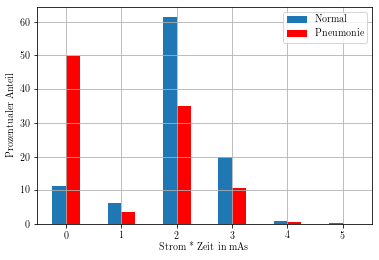

In [29]:
exposure_percentage_normal = [(filtered_exposure_normal.count(x)*100) / len(filtered_exposure_normal) for x in np.arange(42)]
exposure_percentage_pneumonia = [(filtered_exposure_pneumonia.count(x)*100) / len(filtered_exposure_pneumonia) for x in np.arange(42)]

fig, ax = plt.subplots()  # a figure with a single Axes

# bins must be -0.5 to center the x ticks, for detailled explanation see https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
ax.bar(np.arange(6)-0.125, exposure_percentage_normal[:6], width=0.25, label="Normal")
ax.bar(np.arange(6)+0.125, exposure_percentage_pneumonia[:6], color='r', width=0.25, label="Pneumonie")
ax.set_xlabel('Strom * Zeit in mAs')
ax.set_ylabel('Prozentualer Anteil')
ax.legend()
ax.grid(True)

if USE_LATEX_ENGINE:
    plt.savefig("/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_combined_exposure_percentage.pdf")

In [30]:
print('==== Distribution of XRayTubeCurrent_DICOM ====\n')

calculate_percentages(normal_meta_data['XRayTubeCurrent_DICOM'], pneumonia_meta_data['XRayTubeCurrent_DICOM'])

==== Distribution of XRayTubeCurrent_DICOM ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'200', '250', '100', 'None', '400', '320', '500', '125', '0', '160'}
Pneumonia: {'200', '250', '100', 'None', '400', '320', '500', '0', '160'}
Number of appearences (normal):
'200': 17
'250': 13900
'100': 70
'None': 10628
'400': 1920
'320': 4680
'500': 1466
'125': 2
'0': 3194
'160': 31



In [31]:
print('==== Distribution of Exposure_DICOM ====\n')

calculate_percentages(normal_meta_data['Exposure_DICOM'], pneumonia_meta_data['Exposure_DICOM'])


==== Distribution of Exposure_DICOM ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'12', '8', '7', '20', '3', '35', '5', '25', '0', '2', '6', '4', '11', '1', '80', '30', '40', 'None', '10'}
Pneumonia: {'20', '3', '12', '2', 'None', '4', '5', '25', '6', '8', '0', '10', '1'}
Number of appearences (normal):
'12': 45
'8': 12
'7': 1
'20': 6
'3': 5590
'35': 1
'5': 52
'25': 2
'0': 3194
'2': 17384
'6': 39
'4': 219
'11': 1
'1': 1746
'80': 1
'30': 1
'40': 1
'None': 7584
'10': 29



In [32]:
print('==== Distribution of Modality_DICOM ====\n')

calculate_percentages(normal_meta_data['Modality_DICOM'], pneumonia_meta_data['Modality_DICOM'])

==== Distribution of Modality_DICOM ====

{'CR', 'DX'}
                     normal                        pneumonia                     
CR:                  32775/35908 (91.27%)          4986/5220 (95.52%)            
DX:                  3133/35908 (8.73%)            234/5220 (4.48%)              


In [33]:
print('==== Distribution of Manufacturer_DICOM ====\n')

calculate_percentages(normal_meta_data['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'])

==== Distribution of Manufacturer_DICOM ====

{'ImagingDynamicsCompanyLtd', 'PhilipsMedicalSystems'}
                     normal                        pneumonia                     
ImagingDynamicsCompanyLtd: 22110/35908 (61.57%)          1114/5220 (21.34%)            
PhilipsMedicalSystems: 13798/35908 (38.43%)          4106/5220 (78.66%)            


In [34]:
print('==== Distribution of PixelAspectRatio_DICOM ====\n')
calculate_percentages(normal_meta_data['PixelAspectRatio_DICOM'], pneumonia_meta_data['PixelAspectRatio_DICOM'])

==== Distribution of PixelAspectRatio_DICOM ====

{"['1', '1']", 'None'}
                     normal                        pneumonia                     
['1', '1']:          6597/35908 (18.37%)           3109/5220 (59.56%)            
None:                29311/35908 (81.63%)          2111/5220 (40.44%)            


In [35]:
print('==== Distribution of Age ====\n')
calculate_percentages(normal_meta_data['PatientBirth'], pneumonia_meta_data['PatientBirth'])

==== Distribution of Age ====

{1907.0, 1911.0, 1912.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0}
                     normal                        pneumonia                     
1907.0:              1/35908 (0.00%)  

In [36]:
normal_age_list = list()
number_of_normal = list()
for y in set(normal_meta_data['PatientBirth']):
    normal_age_list += [int(y)]
    number_of_normal += [sum(normal_meta_data['PatientBirth'] == y)]

print(normal_age_list)
print(number_of_normal)

[1907, 1911, 1912, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
[1, 2, 2, 3, 2, 6, 9, 8, 10, 7, 32, 37, 34, 46, 95, 90, 111, 114, 146, 178, 194, 204, 288, 337, 331, 338, 362, 370, 322, 495, 373, 356, 482, 560, 524, 574, 599, 582, 558, 523, 597, 582, 606, 596, 620, 635, 699, 691, 734, 727, 726, 762, 753, 779, 765, 786, 778, 805, 707, 825, 705, 726, 735, 659, 636, 541, 501, 490, 480, 420, 382, 339, 317, 334, 314, 303, 266, 32

In [37]:
pneumonia_age_list = list()
number_of_pneumonia = list()
for y in set(pneumonia_meta_data['PatientBirth']):
    pneumonia_age_list += [int(y)]
    number_of_pneumonia += [sum(pneumonia_meta_data['PatientBirth'] == y)]

print(pneumonia_age_list)
print(number_of_pneumonia)

[1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
[3, 1, 3, 7, 9, 9, 13, 8, 22, 23, 43, 42, 42, 61, 46, 49, 75, 100, 80, 114, 84, 121, 109, 94, 92, 99, 97, 97, 68, 107, 94, 78, 114, 96, 79, 80, 102, 81, 87, 63, 73, 54, 44, 55, 71, 59, 60, 57, 55, 50, 43, 58, 58, 56, 54, 54, 55, 29, 44, 49, 46, 49, 39, 45, 38, 28, 34, 26, 30, 16, 22, 17, 25, 25, 11, 13, 22, 23, 13, 9, 7, 12, 16, 5, 13, 4, 13, 10, 16, 13, 26, 17

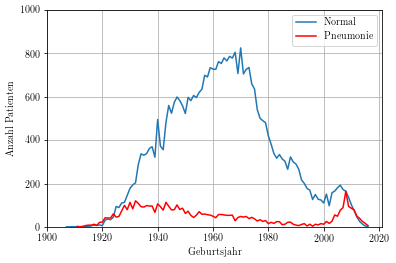

In [38]:
plt.axis([1900, 2021 , 0, 1001])
plt.plot(normal_age_list, number_of_normal, label="Normal")
plt.plot(pneumonia_age_list, number_of_pneumonia, 'r', label="Pneumonie")
plt.ylabel('Anzahl Patienten')
plt.xlabel('Geburtsjahr')
plt.legend()
plt.grid(True)
# plt.show()

if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/year_of_birth_diagram.pdf')


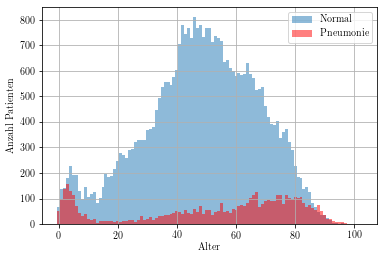

In [39]:
maximum_age = max(max(set(normal_meta_data['Age'])), max(set(pneumonia_meta_data['Age'])))
x_axis_age = np.arange(maximum_age + 2)-0.5 # would be +1 for right aligned, but we want to center the x ticks -> +0.5
plt.hist(normal_meta_data['Age'], x_axis_age, alpha=0.5, label="Normal")
plt.hist(pneumonia_meta_data['Age'], x_axis_age, alpha=0.5, color='r', label="Pneumonie")
plt.ylabel('Anzahl Patienten')
plt.xlabel('Alter')
plt.legend()
plt.grid(True)
# plt.show()

if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_age_histogram.pdf')


In [40]:
set(normal_meta_data)

{'Age',
 'AgeGroup',
 'BitsStored_DICOM',
 'Columns_DICOM',
 'ExposureInuAs_DICOM',
 'ExposureTime',
 'Exposure_DICOM',
 'ImageDir',
 'ImageID',
 'Labels',
 'LabelsLocalizationsBySentence',
 'Localizations',
 'LocalizationsCUIS',
 'Manufacturer_DICOM',
 'MethodLabel',
 'MethodProjection',
 'Modality_DICOM',
 'PatientBirth',
 'PatientID',
 'PatientSex_DICOM',
 'Pediatric',
 'PhotometricInterpretation_DICOM',
 'PixelAspectRatio_DICOM',
 'PixelRepresentation_DICOM',
 'Projection',
 'ProjectionSimplified',
 'RelativeXRayExposure_DICOM',
 'Report',
 'ReportID',
 'Rows_DICOM',
 'SpatialResolution_DICOM',
 'StudyDate_DICOM',
 'StudyID',
 'Unnamed: 0',
 'ViewPosition_DICOM',
 'WindowCenter_DICOM',
 'WindowWidth_DICOM',
 'XRayTubeCurrent_DICOM',
 'labelCUIS'}

In [41]:
duplicate_patients = set(normal_meta_data['PatientID']) & set(pneumonia_meta_data['PatientID'])
print(str(len(duplicate_patients)) + ' Patients are both in Normal and Pneumonia data present')
print('Total number of Patients:\nNormal: ' + str(len(set(normal_meta_data['PatientID']))) + '\nPneumonia: ' + str(len(set(pneumonia_meta_data['PatientID']))))

694 Patients are both in Normal and Pneumonia data present
Total number of Patients:
Normal: 29845
Pneumonia: 4210


In [42]:
qry = ''
first = True
for id in list(duplicate_patients):
    if first:
        qry = qry + 'PatientID == \'' + str(id) + '\''
        first = False
    else:
        qry = qry + ' | PatientID == \'' + str(id) + '\''
duplicate_df = normal_meta_data.query(qry)

In [43]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'])
calculate_percentages(duplicate_df['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'])

{'PA', 'AP'}
                     normal                        pneumonia                     
PA:                  34235/35908 (95.34%)          3400/5220 (65.13%)            
AP:                  1673/35908 (4.66%)            1820/5220 (34.87%)            
{'PA', 'AP'}
                     normal                        pneumonia                     
PA:                  860/930 (92.47%)              3400/5220 (65.13%)            
AP:                  70/930 (7.53%)                1820/5220 (34.87%)            


# Filtering for final Dataset

## Patients who have images with and without pneumonia
All samples of these patients labeled with normal + projection PA will be removed from the dataset, to make sure their "normal" images don't show a light pneumonia.<br>
normal label + AP will be kept, as the combination of AP + normal is rare

In [44]:
print("Dropping", sum(duplicate_df['ProjectionSimplified'] == 'PA'), "samples labeled as normal + projection PA whose patients also have samples with pneumonia label")

print(len(normal_meta_data))
normal_meta_data.drop(duplicate_df.query("ProjectionSimplified == 'PA'").index, inplace=True)
print(len(normal_meta_data))



Dropping 860 samples labeled as normal + projection PA whose patients also have samples with pneumonia label
35908
35048
/home/jan/miniconda3/envs/embeddedIntelligence/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [45]:
calculate_percentages(duplicate_df.query("ProjectionSimplified == 'AP'")['MethodLabel'], pneumonia_meta_data['MethodLabel'])
calculate_percentages(normal_meta_data['MethodLabel'], pneumonia_meta_data['MethodLabel'])

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           6/70 (8.57%)                  1094/5220 (20.96%)            
RNN_model:           64/70 (91.43%)                4126/5220 (79.04%)            
{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           8812/35048 (25.14%)           1094/5220 (20.96%)            
RNN_model:           26236/35048 (74.86%)          4126/5220 (79.04%)            


# Experimantal random sampling

In [46]:

filtered_normal_meta = []
copy_normal_meta_imagingdynamics = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "ImagingDynamicsCompanyLtd"]
copy_normal_meta_philips = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "PhilipsMedicalSystems"]

random_imagingdynamics = copy_normal_meta_imagingdynamics.sample(n = 1114)
random_philips = copy_normal_meta_philips.sample(n = 4106)
random_normal = random_imagingdynamics.append(random_philips)
print(len(random_imagingdynamics))
print(len(random_philips))
print(len(random_normal))


1114
4106
5220


In [47]:
print('==== Distribution of projections ====\n')
calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'], random_normal['Projection'])

==== Distribution of projections ====

{'PA', 'AP_horizontal', 'AP'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33375/35048 (95.23%)          4719/5220 (90.40%)            3400/5220 (65.13%)            
AP_horizontal:       1061/35048 (3.03%)            331/5220 (6.34%)              1330/5220 (25.48%)            
AP:                  612/35048 (1.75%)             170/5220 (3.26%)              490/5220 (9.39%)              


In [48]:
find_appearences(normal_meta_data, 'Projection', 'COSTAL')

found 0 rows
Indexes: []


[]

In [49]:

filtered_normal_meta = []
copy_normal_meta_imagingdynamics = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "ImagingDynamicsCompanyLtd"]
copy_normal_meta_philips = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "PhilipsMedicalSystems"]

random_imagingdynamics = copy_normal_meta_imagingdynamics.sample(n = 1116)
random_philips = copy_normal_meta_philips.sample(n = 4107)
random_normal = random_imagingdynamics.append(random_philips)

print("ImagingDynamics: " + str(len(random_imagingdynamics)) + '/' + str(len(copy_normal_meta_imagingdynamics)))
print("Philips; " + str(len(random_philips)) + '/' + str(len(copy_normal_meta_philips)))
print(len(random_normal))

# random_normal = normal_meta_data.sample(n = len(pneumonia_meta_data))

print('==== Distribution of projections ====\n')
calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'], random_normal['Projection'])

ImagingDynamics: 1116/21529
Philips; 4107/13519
5223
==== Distribution of projections ====

{'PA', 'AP_horizontal', 'AP'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33375/35048 (95.23%)          4754/5223 (91.02%)            3400/5220 (65.13%)            
AP_horizontal:       1061/35048 (3.03%)            317/5223 (6.07%)              1330/5220 (25.48%)            
AP:                  612/35048 (1.75%)             152/5223 (2.91%)              490/5220 (9.39%)              


In [50]:
print('==== Distribution of Manufacturers ====\n')
calculate_percentages(normal_meta_data['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'], random_normal['Manufacturer_DICOM'])

==== Distribution of Manufacturers ====

{'ImagingDynamicsCompanyLtd', 'PhilipsMedicalSystems'}
                     normal (total)                normal (filtered)             pneumonia                     
ImagingDynamicsCompanyLtd: 21529/35048 (61.43%)          1116/5223 (21.37%)            1114/5220 (21.34%)            
PhilipsMedicalSystems: 13519/35048 (38.57%)          4107/5223 (78.63%)            4106/5220 (78.66%)            


In [51]:
print('==== Distribution of MethodLabel ====\n')
calculate_percentages(random_normal['MethodLabel'], pneumonia_meta_data['MethodLabel'])

==== Distribution of MethodLabel ====

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           1995/5223 (38.20%)            1094/5220 (20.96%)            
RNN_model:           3228/5223 (61.80%)            4126/5220 (79.04%)            


In [52]:
print('==== Distribution of Patient Sex ====\n')
calculate_percentages(random_normal['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])

==== Distribution of Patient Sex ====

{'M', 'F'}
                     normal                        pneumonia                     
M:                   2279/5223 (43.63%)            2962/5220 (56.74%)            
F:                   2944/5223 (56.37%)            2258/5220 (43.26%)            


In [53]:
print('==== Distribution of Modality_DICOM ====\n')
calculate_percentages(random_normal['Modality_DICOM'], pneumonia_meta_data['Modality_DICOM'])

==== Distribution of Modality_DICOM ====

{'CR', 'DX'}
                     normal                        pneumonia                     
CR:                  4271/5223 (81.77%)            4986/5220 (95.52%)            
DX:                  952/5223 (18.23%)             234/5220 (4.48%)              


In [54]:
print('==== Distribution of Manufacturer_DICOM ====\n')
calculate_percentages(random_normal['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'])

==== Distribution of Manufacturer_DICOM ====

{'ImagingDynamicsCompanyLtd', 'PhilipsMedicalSystems'}
                     normal                        pneumonia                     
ImagingDynamicsCompanyLtd: 1116/5223 (21.37%)            1114/5220 (21.34%)            
PhilipsMedicalSystems: 4107/5223 (78.63%)            4106/5220 (78.66%)            


In [55]:
print('==== Distribution of MethodLabel ====\n')
calculate_percentages(random_normal['MethodLabel'], pneumonia_meta_data['MethodLabel'])

==== Distribution of MethodLabel ====

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           1995/5223 (38.20%)            1094/5220 (20.96%)            
RNN_model:           3228/5223 (61.80%)            4126/5220 (79.04%)            


In [56]:
print('==== Distribution of MethodProjection ====\n')
calculate_percentages(random_normal['MethodProjection'], pneumonia_meta_data['MethodProjection'])

==== Distribution of MethodProjection ====

{'Manual review of DICOM fields', 'resnet-50.t7'}
                     normal                        pneumonia                     
Manual review of DICOM fields: 4237/5223 (81.12%)            4761/5220 (91.21%)            
resnet-50.t7:        986/5223 (18.88%)             459/5220 (8.79%)              


# Stratified Sampling from Kaggle

In [57]:
'''
This module contains functions that computes stratified sampling of pandas dataframes.
'''
# Required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Functions

In [58]:
def __smpl_size(population, size):
    '''
    A function to compute the sample size. If not informed, a sampling 
    size will be calculated using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Parameters
    ----------
        :population: population size
        :size: sample size (default = None)
    Returns
    -------
    Calculated sample size to be used in the functions:
        - stratified_sample
        - stratified_sample_report
    '''
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

In [59]:
def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.

    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size

    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


In [60]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df


In [61]:
def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.

    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size

    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd

In [62]:
def stratified_sample_transferred(df_target, df_proportion, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df_target: pandas dataframe from which data will be sampled.
    :df_proportion: pandas dataframe from which the proportions for sampling will be used.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    
    # population = len(df)
    # size = __smpl_size(population, size)
    # tmp = df[strata]
    # tmp['size'] = 1
    # tmp_grpd = tmp.groupby(strata).count().reset_index()
    # tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)


    population = len(df_proportion)
    size = __smpl_size(population, size)

    tmp_proportion = df_proportion[strata]
    tmp = df_target[strata]

    tmp_proportion['size'] = 1
    tmp['size'] = 1

    tmp_proportion_grpd = tmp_proportion.groupby(strata).count().reset_index()
    tmp_grpd = tmp.groupby(strata).count().reset_index()

    if not tmp_grpd[strata].equals(tmp_proportion_grpd[strata]):
        print(tmp_grpd)
        print(tmp_proportion_grpd)
        raise ValueError("Dataframes don't have the same groups for the given set of stratas. You can check the differences in the terminal output.")        

    tmp_proportion_grpd['samp_size'] = round(size/population * tmp_proportion_grpd['size']).astype(int)
    tmp_grpd['samp_size'] = round(size/population * tmp_proportion_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    # Hier muss nichts geändert werden, da die Gruppen ohnehin die gleichen sein sollten -> len(tmp_grpd) == len(tmp_proportion_grpd)
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            # Hier wird n berechnet, tmp_proportion_grpd statt tmp_grpd
            
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # query dataframe
        queried_df = df_target.query(qry)

        # check if result contains enough samples / rows
        if len(queried_df) < n:
            print("Warning! The required number of samples (" + str(n) + ") could not be retrieved.")
            print("Using all available entries (" + str(len(queried_df)) + ") of group:")
            print(qry)
            n = len(queried_df)

        # sample dataframe
        sampled_df = queried_df.sample(n=n, random_state=seed).reset_index(drop=(not keep_index))

        # assign to final dataframe
        if first:
            stratified_df = sampled_df
            first = False
        else:
            stratified_df = stratified_df.append(sampled_df, ignore_index=True)
    
    return stratified_df

In [63]:
stratified_sample_report(normal_meta_data, ['Manufacturer_DICOM', 'Projection', 'PatientSex_DICOM'], size=2000)


,Manufacturer_DICOM,Projection,PatientSex_DICOM,size,samp_size
0,ImagingDynamicsCompanyLtd,AP,F,61,3
1,ImagingDynamicsCompanyLtd,AP,M,72,4
2,ImagingDynamicsCompanyLtd,PA,F,12410,708
3,ImagingDynamicsCompanyLtd,PA,M,8986,513
4,PhilipsMedicalSystems,AP,F,210,12
5,PhilipsMedicalSystems,AP,M,269,15
6,PhilipsMedicalSystems,AP_horizontal,F,452,26
7,PhilipsMedicalSystems,AP_horizontal,M,609,35
8,PhilipsMedicalSystems,PA,F,7029,401
9,PhilipsMedicalSystems,PA,M,4950,282


In [64]:
indexes = find_appearences(normal_meta_data, 'Projection', 'AP_horizontal')

found 1061 rows
Indexes: [17, 64, 80, 151, 208, 209, 220, 306, 326, 386, 418, 458, 461, 496, 515, 533, 584, 680, 709, 751, 1078, 1118, 1291, 1460, 1544, 1652, 1760, 2007, 2044, 2045, 2086, 2087, 2114, 2202, 2217, 2300, 2321, 2355, 2375, 2401, 2553, 2590, 2607, 2680, 2715, 2737, 2919, 3219, 3359, 3360, 3373, 3763, 3783, 3848, 4030, 4080, 4181, 4182, 4231, 4350, 4441, 4578, 4677, 4685, 4729, 4839, 4882, 5130, 5197, 5211, 5218, 5458, 5466, 5513, 5779, 5809, 5811, 6062, 6128, 6141, 6217, 6451, 6978, 7057, 7141, 7146, 7148, 7378, 7380, 7636, 7688, 7730, 7857, 7896, 8113, 8219, 8417, 8500, 8507, 8544, 8694, 8788, 8925, 8983, 9023, 9209, 9321, 9322, 9407, 9937, 9957, 9964, 10034, 10304, 10316, 10333, 10354, 10406, 10591, 10595, 10923, 10997, 11034, 11136, 11152, 11162, 11168, 11195, 11247, 11291, 11346, 11629, 11663, 11703, 11832, 11969, 12077, 12079, 12112, 12251, 12278, 12532, 12598, 12612, 12703, 12718, 12737, 12767, 12819, 12839, 12856, 12900, 12936, 13036, 13056, 13066, 13173, 13176, 132

In [65]:
# import matplotlib.image as mpimg
# import random

# fig_nr = 1

# for i in random.sample(indexes, 10):
#     plt.figure(fig_nr)
#     fig_nr += 1
#     img = mpimg.imread('/mnt/f/BIMCV-PadChest/unzipped/' + str(normal_meta_data.loc[i]['ImageDir']) + '/' + str(normal_meta_data.loc[i]['ImageID']))
#     imgplot = plt.imshow(img, cmap="gray")
# plt.show()

In [66]:
stratified_sample_report(normal_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'AgeGroup'])

,Manufacturer_DICOM,Modality_DICOM,PatientSex_DICOM,ProjectionSimplified,AgeGroup,size,samp_size
0,ImagingDynamicsCompanyLtd,CR,F,AP,1.0,7,0
1,ImagingDynamicsCompanyLtd,CR,F,AP,2.0,33,2
2,ImagingDynamicsCompanyLtd,CR,F,AP,3.0,21,1
3,ImagingDynamicsCompanyLtd,CR,F,PA,1.0,216,14
4,ImagingDynamicsCompanyLtd,CR,F,PA,2.0,8822,566
5,ImagingDynamicsCompanyLtd,CR,F,PA,3.0,3372,216
6,ImagingDynamicsCompanyLtd,CR,M,AP,1.0,21,1
7,ImagingDynamicsCompanyLtd,CR,M,AP,2.0,35,2
8,ImagingDynamicsCompanyLtd,CR,M,AP,3.0,16,1
9,ImagingDynamicsCompanyLtd,CR,M,PA,1.0,319,20


In [67]:
stratified_sample_report(pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'MethodProjection', 'AgeGroup'])

,Manufacturer_DICOM,Modality_DICOM,PatientSex_DICOM,ProjectionSimplified,MethodProjection,AgeGroup,size,samp_size
0,ImagingDynamicsCompanyLtd,CR,F,AP,Manual review of DICOM fields,1.0,1,0
1,ImagingDynamicsCompanyLtd,CR,F,AP,Manual review of DICOM fields,2.0,1,0
2,ImagingDynamicsCompanyLtd,CR,F,PA,Manual review of DICOM fields,1.0,36,11
3,ImagingDynamicsCompanyLtd,CR,F,PA,Manual review of DICOM fields,2.0,305,96
4,ImagingDynamicsCompanyLtd,CR,F,PA,Manual review of DICOM fields,3.0,187,59
5,ImagingDynamicsCompanyLtd,CR,M,AP,Manual review of DICOM fields,1.0,8,3
6,ImagingDynamicsCompanyLtd,CR,M,AP,Manual review of DICOM fields,2.0,4,1
7,ImagingDynamicsCompanyLtd,CR,M,AP,Manual review of DICOM fields,3.0,1,0
8,ImagingDynamicsCompanyLtd,CR,M,PA,Manual review of DICOM fields,1.0,42,13
9,ImagingDynamicsCompanyLtd,CR,M,PA,Manual review of DICOM fields,2.0,234,74


In [68]:
filtered_df = stratified_sample_transferred(normal_meta_data, pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'MethodProjection', 'ProjectionSimplified'], size=len(pneumonia_meta_data))

print('\nFiltered dataframe has', len(filtered_df), 'samples')

Warning! The required number of samples (696) could not be retrieved.
Using all available entries (660) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'F' & MethodProjection == 'Manual review of DICOM fields' & ProjectionSimplified == 'AP'
Warning! The required number of samples (1084) could not be retrieved.
Using all available entries (868) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'M' & MethodProjection == 'Manual review of DICOM fields' & ProjectionSimplified == 'AP'
Warning! The required number of samples (10) could not be retrieved.
Using all available entries (2) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'F' & MethodProjection == 'Manual review of DICOM fields' & ProjectionSimplified == 'AP'
Warning! The required number of samples (15) could not be retrieved.
Using all available entries (10) of group:
Ma

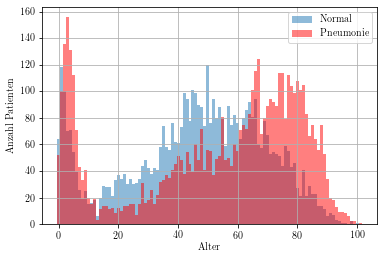

In [69]:
maximum_age = max(max(set(filtered_df['Age'])), max(set(pneumonia_meta_data['Age'])))
x_axis_age = np.arange(maximum_age + 2)-0.5 # would be +1 for right aligned, but we want to center the x ticks -> +0.5

plt.hist(filtered_df['Age'], x_axis_age, alpha=0.5, label="Normal")
plt.hist(pneumonia_meta_data['Age'], x_axis_age, alpha=0.5, color='r', label="Pneumonie")
plt.ylabel('Anzahl Patienten')
plt.xlabel('Alter')
plt.legend()
plt.grid(True)

if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padches t_age_histogram_no_groups.pdf')

In [70]:
total_error = 0
for age in np.arange(max(max(filtered_df['Age']), max(pneumonia_meta_data['Age']))):
    error = abs(list(filtered_df['Age']).count(age) - list(pneumonia_meta_data['Age']).count(age))
    # print(error)
    total_error += error
print('Total error was:', total_error)

Total error was: 2866


In [71]:
qry = "(Manufacturer_DICOM == 'ImagingDynamicsCompanyLtd' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == '3.0')"
qry = qry + " | (Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == '2.0')"
qry = qry + " | (Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'M' & ProjectionSimplified == 'AP' & AgeGroup == '2.0')"
dropped_samples = normal_meta_data.query(qry)
normal_meta_data.drop(dropped_samples.index, inplace=True)

print(len(dropped_samples), 'samples were temporarily removed')

26 samples were temporarily removed


In [72]:
filtered_df = stratified_sample_transferred(normal_meta_data, pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'AgeGroup'], size=len(pneumonia_meta_data) + 266) # 248 was determined empirically so the length of the filtered dataframe + all remaining ap samples matches the length of pneumonia data
# missing values: 'MethodLabel'

Warning! The required number of samples (427) could not be retrieved.
Using all available entries (238) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == 3.0
Warning! The required number of samples (657) could not be retrieved.
Using all available entries (287) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'M' & ProjectionSimplified == 'AP' & AgeGroup == 3.0
Warning! The required number of samples (11) could not be retrieved.
Using all available entries (1) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == 1.0
Warning! The required number of samples (11) could not be retrieved.
Using all available entries (3) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'M' & ProjectionSim

In [73]:
len(filtered_df)

4910

In [74]:
stratified_sample_report(pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'AgeGroup', 'ProjectionSimplified'], size=len(pneumonia_meta_data))

,Manufacturer_DICOM,Modality_DICOM,PatientSex_DICOM,AgeGroup,ProjectionSimplified,size,samp_size
0,ImagingDynamicsCompanyLtd,CR,F,1.0,AP,1,1
1,ImagingDynamicsCompanyLtd,CR,F,1.0,PA,36,36
2,ImagingDynamicsCompanyLtd,CR,F,2.0,AP,1,1
3,ImagingDynamicsCompanyLtd,CR,F,2.0,PA,305,305
4,ImagingDynamicsCompanyLtd,CR,F,3.0,PA,187,187
5,ImagingDynamicsCompanyLtd,CR,M,1.0,AP,8,8
6,ImagingDynamicsCompanyLtd,CR,M,1.0,PA,42,42
7,ImagingDynamicsCompanyLtd,CR,M,2.0,AP,4,4
8,ImagingDynamicsCompanyLtd,CR,M,2.0,PA,234,234
9,ImagingDynamicsCompanyLtd,CR,M,3.0,AP,1,1


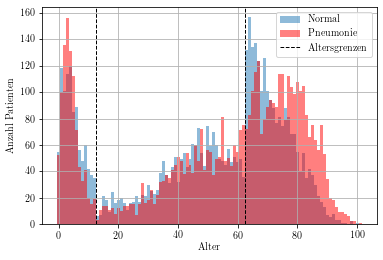

In [75]:
maximum_age = max(max(set(filtered_df['Age'])), max(set(pneumonia_meta_data['Age'])))
x_axis_age = np.arange(maximum_age + 2)-0.5 # would be +1 for right aligned, but we want to center the x ticks -> +0.5


plt.hist(filtered_df['Age'], x_axis_age, alpha=0.5, label="Normal")
plt.hist(pneumonia_meta_data['Age'], x_axis_age, alpha=0.5, color='r', label="Pneumonie")
plt.axvline(x=FIRST_GROUP_BOUNDARY + 0.5, label='Altersgrenzen', c='k', linestyle='--', linewidth=1)
plt.axvline(x=SECOND_GROUP_BOUNDARY + 0.5, c='k', linestyle='--', linewidth=1)
plt.ylabel('Anzahl Patienten')
plt.xlabel('Alter')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]     # order in the array determines position, number in the array is the original order
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.grid(True)


if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_age_histogram_with_groups.pdf')

In [76]:
total_error = 0
for age in np.arange(max(max(filtered_df['Age']), max(pneumonia_meta_data['Age']))):
    error = abs(list(filtered_df['Age']).count(age) - list(pneumonia_meta_data['Age']).count(age))
    # print(error)
    total_error += error
print('Total error was:', total_error)



Total error was: 1735


In [77]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'], filtered_df['ProjectionSimplified'])

{'PA', 'AP'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33375/35022 (95.30%)          3575/4910 (72.81%)            3400/5220 (65.13%)            
AP:                  1647/35022 (4.70%)            1335/4910 (27.19%)            1820/5220 (34.87%)            


In [78]:
remaining_ap_df = normal_meta_data.copy()
remaining_ap_df.drop(filtered_df['index'], inplace=True)

In [79]:
remaining_ap = remaining_ap_df.query("ProjectionSimplified == 'AP'")
print(len(remaining_ap))
filtered_df = filtered_df.append(remaining_ap)

312


In [80]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'], filtered_df['ProjectionSimplified'])
calculate_percentages(filtered_df['MethodLabel'], pneumonia_meta_data['MethodLabel'])
calculate_percentages(filtered_df['MethodProjection'], pneumonia_meta_data['MethodProjection'])
calculate_percentages(filtered_df['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'])
calculate_percentages(filtered_df['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])


{'PA', 'AP'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33375/35022 (95.30%)          3575/5222 (68.46%)            3400/5220 (65.13%)            
AP:                  1647/35022 (4.70%)            1647/5222 (31.54%)            1820/5220 (34.87%)            
{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           1262/5222 (24.17%)            1094/5220 (20.96%)            
RNN_model:           3960/5222 (75.83%)            4126/5220 (79.04%)            
{'Manual review of DICOM fields', 'resnet-50.t7'}
                     normal                        pneumonia                     
Manual review of DICOM fields: 4497/5222 (86.12%)            4761/5220 (91.21%)            
resnet-50.t7:        725/5222 (13.88%)             459/5220 (8.79%)              
{'ImagingDynamicsCompanyLtd', 'PhilipsMedicalSystems'}
                 

In [81]:
calculate_percentages(filtered_df['BitsStored_DICOM'], pneumonia_meta_data['BitsStored_DICOM'])
calculate_percentages(filtered_df['SpatialResolution_DICOM'], pneumonia_meta_data['SpatialResolution_DICOM'])


{10, 12}
                     normal                        pneumonia                     
10:                  911/5222 (17.45%)             583/5220 (11.17%)             
12:                  4311/5222 (82.55%)            4637/5220 (88.83%)            
{'0.148', '0.1500000059604', '0.182', 'None', '0.2000000029802', '0.2', '0.15', '0.143', '0.1500000059605'}
                     normal                        pneumonia                     
0.148:               227/5222 (4.35%)              232/5220 (4.44%)              
0.1500000059604:     11/5222 (0.21%)               3/5220 (0.06%)                
0.182:               13/5222 (0.25%)               63/5220 (1.21%)               
None:                2179/5222 (41.73%)            1699/5220 (32.55%)            
0.2000000029802:     359/5222 (6.87%)              143/5220 (2.74%)              
0.2:                 1283/5222 (24.57%)            1552/5220 (29.73%)            
0.15:                369/5222 (7.07%)              262/5220 (5.

In [82]:
calculate_percentages(filtered_df['ViewPosition_DICOM'], pneumonia_meta_data['ViewPosition_DICOM'])

{'PA', 'nan', 'ANTEROPOSTERIOR', 'POSTEROANTERIOR', 'AP'}
                     normal                        pneumonia                     
PA:                  220/5222 (4.21%)              209/5220 (4.00%)              
nan:                 3727/5222 (71.37%)            3872/5220 (74.18%)            
ANTEROPOSTERIOR:     112/5222 (2.14%)              15/5220 (0.29%)               
POSTEROANTERIOR:     1156/5222 (22.14%)            1099/5220 (21.05%)            
AP:                  7/5222 (0.13%)                25/5220 (0.48%)               


# Store results as csv files

In [83]:
filtered_df.to_csv('./normal_meta_data_filtered.csv')
pneumonia_meta_data.to_csv('./pneumonia_meta_data_filtered.csv')